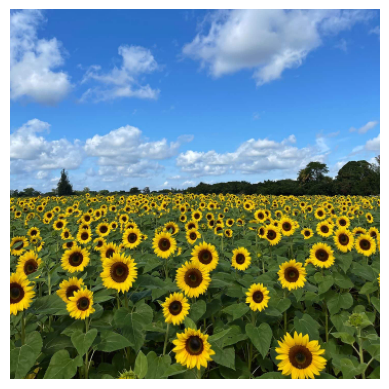

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("a2images/the_berry_farms_sunflower_field.jpeg", cv2.IMREAD_REDUCED_COLOR_4)
assert img is not None

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Range of  2 - 30  sigma values are used.
The maximum estimated standard deviation:  42.42640687119285


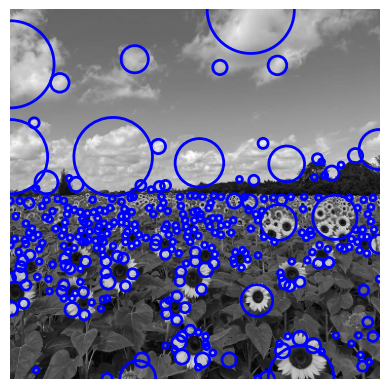

In [11]:
from skimage.feature import blob_log
import math

img_orig = cv.imread("a2images/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)

blobs = blob_log(img_gray, min_sigma=2, max_sigma=30, num_sigma=20, threshold=.1)
a = max(blobs[:, 2])
blobs[:, 2] = blobs[:, 2] * math.sqrt(2)
b = max(blobs[:, 2])

fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')
ax.axis('off')

for b in blobs:
    y, x, r = b
    c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
    ax.add_patch(c)
    

print('Range of ', 2, '-', 30, ' sigma values are used.')    
print('The maximum estimated standard deviation: ', max(blobs[:, 2]))

plt.show()

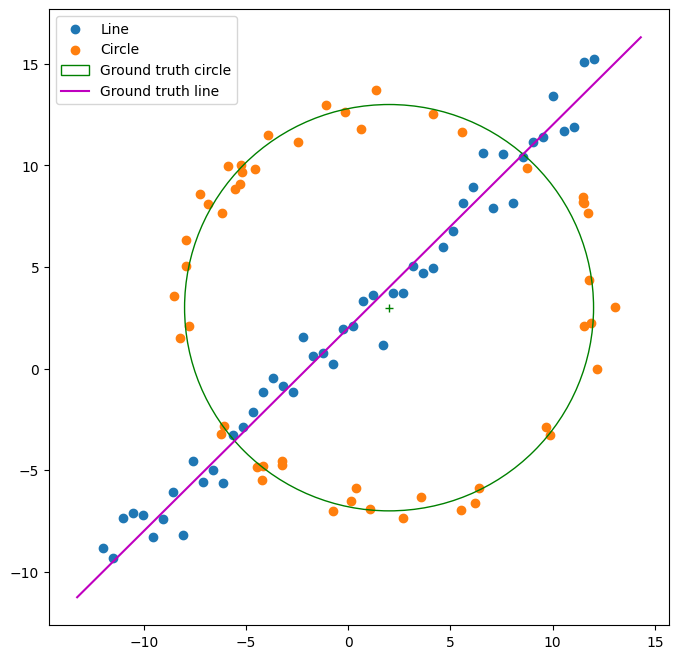

In [1]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = 1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

### Qusetion 2

Best Line Parameters: a=0.6678653134218507, b=-0.7442821529016621, d=1.6856960947717878, inliers=29


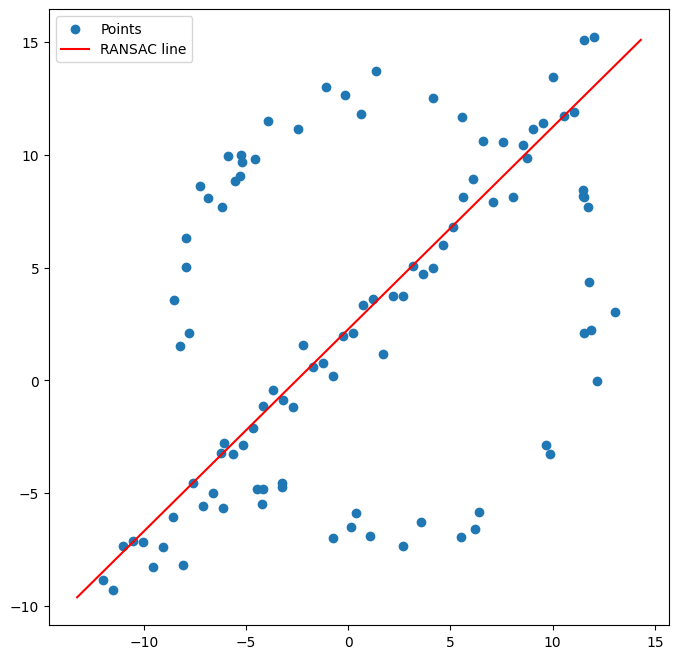

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute distance of points from a line
def compute_distances(points, a, b, d):
    # Using |a*x + b*y + d| since [a,b] is a unit vector (constraint ∥[a,b]∥=1)
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + d)
    return distances

# Function to fit a line from two points
def fit_line_from_points(p1, p2):
    # The line through p1=(x1, y1) and p2=(x2, y2)
    # Ax + By + C = 0, where (A,B) is the normal vector to the line
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    
    # Normal vector to the line (A,B) = (-delta_y, delta_x)
    a = -delta_y
    b = delta_x
    
    # Normalize [a, b] to satisfy ∥[a, b]∥=1
    norm = np.sqrt(a**2 + b**2)
    a /= norm
    b /= norm
    
    # Distance from the origin (perpendicular distance)
    d = -(a * p1[0] + b * p1[1])
    
    return a, b, d

# RANSAC algorithm
def ransac_line_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_a, best_b, best_d = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample two points
        random_indices = np.random.choice(n_points, 2, replace=False)
        p1, p2 = points[random_indices]
        
        # Fit a line using the two points
        a, b, d = fit_line_from_points(p1, p2)
        
        # Compute distances of all points from the line
        distances = compute_distances(points, a, b, d)
        
        # Identify inliers (points within the distance threshold)
        inliers = points[distances < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_a, best_b, best_d = a, b, d
            best_inliers_count = inliers_count
    
    return best_a, best_b, best_d, best_inliers_count

# Parameters for RANSAC
num_iterations = 1000
distance_threshold = 0.5  # Distance threshold to consider a point an inlier
min_inliers = 5  # Minimum number of inliers to accept the model

# Run RANSAC on the noisy points
best_a, best_b, best_d, best_inliers_count = ransac_line_fitting(X, num_iterations, distance_threshold, min_inliers)

print(f"Best Line Parameters: a={best_a}, b={best_b}, d={best_d}, inliers={best_inliers_count}")

# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

plt.legend()
plt.show()

Best Circle Parameters: xc=1.9104297689699945, yc=2.6424602161425077, r=10.013979911216186, inliers=31


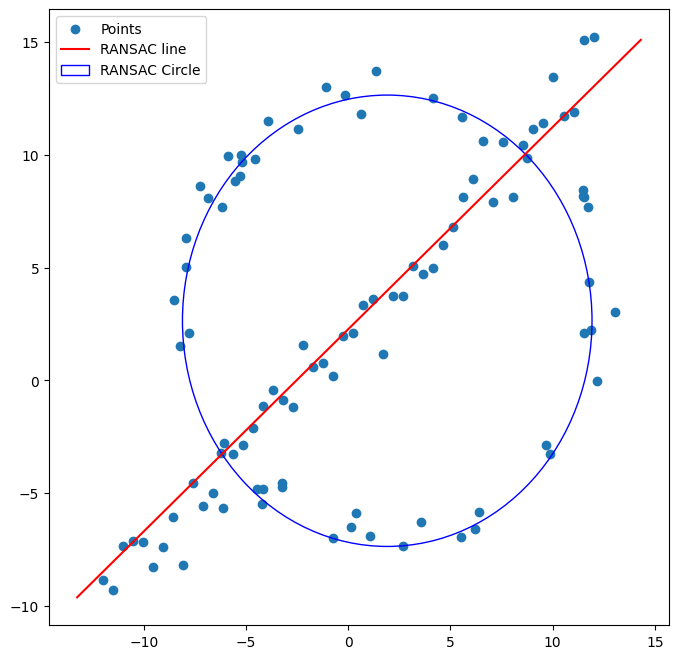

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the center and radius of a circle given 3 points
def circle_from_points(p1, p2, p3):
    # Using the equations of the perpendicular bisectors of the lines formed by p1-p2 and p2-p3
    A = np.array([[p2[0] - p1[0], p2[1] - p1[1]], [p3[0] - p2[0], p3[1] - p2[1]]])
    b = np.array([0.5 * (p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2), 0.5 * (p3[0]**2 - p2[0]**2 + p3[1]**2 - p2[1]**2)])
    center = np.linalg.solve(A, b)
    
    # Radius is the distance from the center to any of the points (we choose p1)
    radius = np.sqrt((center[0] - p1[0])**2 + (center[1] - p1[1])**2)
    
    return center[0], center[1], radius

# Function to compute radial distance of points from the circle
def radial_distances(points, xc, yc, r):
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    radial_error = np.abs(distances - r)
    return radial_error

# RANSAC algorithm for circle fitting
def ransac_circle_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_xc, best_yc, best_r = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample three points
        random_indices = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = points[random_indices]
        
        # Fit a circle using the three points
        try:
            xc, yc, r = circle_from_points(p1, p2, p3)
        except np.linalg.LinAlgError:
            # Skip if the points are collinear and cannot define a circle
            continue
        
        # Compute radial distances of all points from the circle
        radial_error = radial_distances(points, xc, yc, r)
        
        # Identify inliers (points within the radial error threshold)
        inliers = points[radial_error < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_xc, best_yc, best_r = xc, yc, r
            best_inliers_count = inliers_count
            best_sample_points = [p1, p2, p3]

    return best_xc, best_yc, best_r, best_inliers_count, np.array(best_sample_points)


# Subtract the line inliers to get the remnant (circle points)
line_inliers = compute_distances(X, best_a, best_b, best_d) < distance_threshold
X_remnant = X[~line_inliers]

# Parameters for RANSAC circle fitting
circle_num_iterations = 1000
circle_distance_threshold = 0.5  # Radial error threshold to consider a point an inlier
circle_min_inliers = 20  # Minimum number of inliers to accept the circle model

# Run RANSAC for circle fitting on the remnant points
best_xc, best_yc, best_r, best_circle_inliers_count, best_sample_points = ransac_circle_fitting(X_remnant, circle_num_iterations, circle_distance_threshold, circle_min_inliers)

print(f"Best Circle Parameters: xc={best_xc}, yc={best_yc}, r={best_r}, inliers={best_circle_inliers_count}")

# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

# Plot the best circle found by RANSAC
circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, label='RANSAC Circle')
ax.add_patch(circle_plot)

plt.legend()
plt.show()

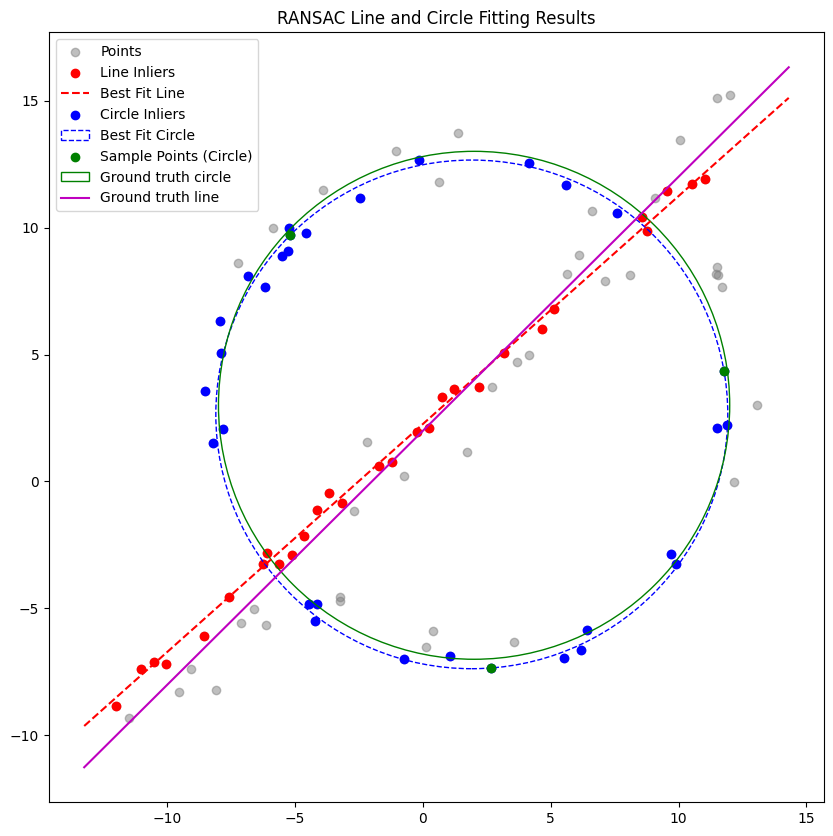

In [4]:
# Create the plot
def plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the point set
    ax.scatter(X[:, 0], X[:, 1], color='gray', label='Points', alpha=0.5)
    
    # Plot the line inliers
    ax.scatter(X[line_inliers, 0], X[line_inliers, 1], color='red', label='Line Inliers')
    
    # Plot the best estimate line
    x_vals = np.array(ax.get_xlim())
    y_vals = -(best_a * x_vals + best_d) / best_b
    ax.plot(x_vals, y_vals, 'r--', label='Best Fit Line')
    
    # Plot the circle inliers
    ax.scatter(X_remnant[circle_inliers, 0], X_remnant[circle_inliers, 1], color='blue', label='Circle Inliers')
    
    # Plot the best estimate circle
    circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, linestyle='--', label='Best Fit Circle')
    ax.add_patch(circle_plot)
    
    # Plot the three points that defined the circle
    ax.scatter(best_sample_points[:, 0], best_sample_points[:, 1], color='green', marker='o', label='Sample Points (Circle)', zorder=5)
    
    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    plt.title("RANSAC Line and Circle Fitting Results")
    plt.show()


# Find circle inliers based on the best circle
circle_inliers = radial_distances(X_remnant, best_xc, best_yc, best_r) < circle_distance_threshold

# Plot the final results
plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers)

### Question 3

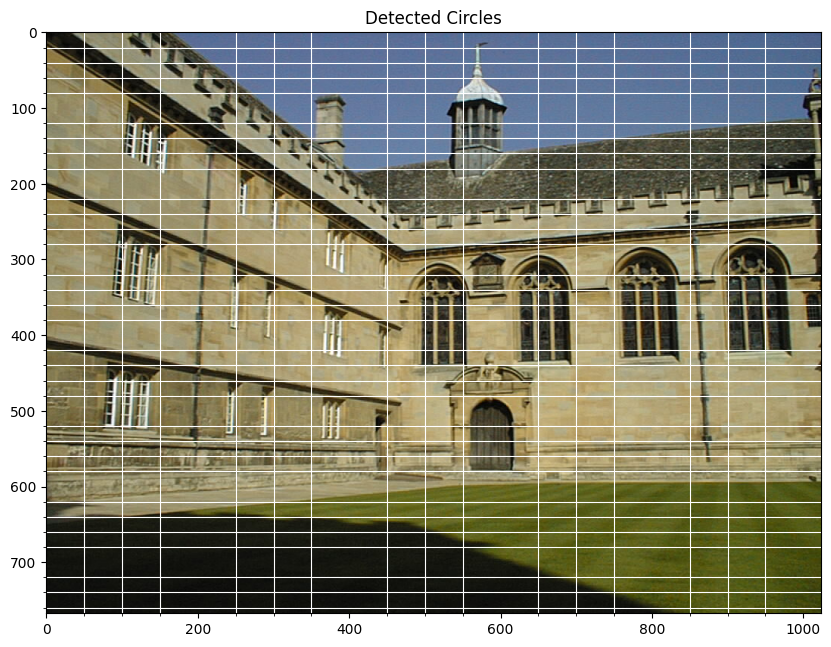

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("a2images/005.jpg")
assert img is not None

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')

plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', color='white')

plt.show()

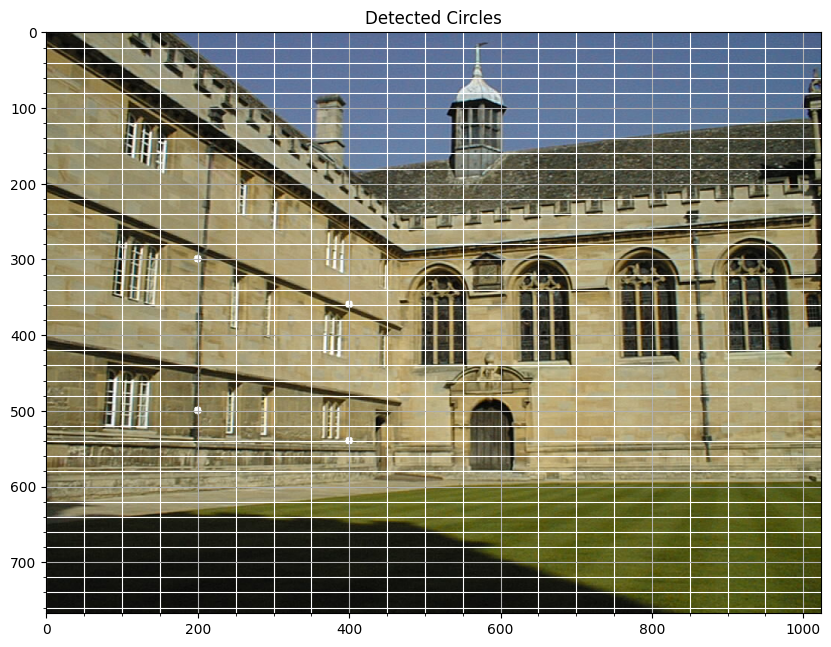

In [13]:
points_img = np.array([[200,300], [200,500], [400,360], [400,540]], dtype='float32')

img2 = img.copy()
# Specify the dot properties
color = (255, 255, 255)  # White color in BGR
radius = 5               # Radius of the dot
thickness = -1           # Thickness of the dot (filled)

# Draw dots on the image
for center_coordinates in points_img:
    # Draw the dot on the image
    cv2.circle(img2, (int(center_coordinates[0]), int(center_coordinates[1])), radius, color, thickness)

# Display the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.grid(True)

plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', color='white')

plt.show()

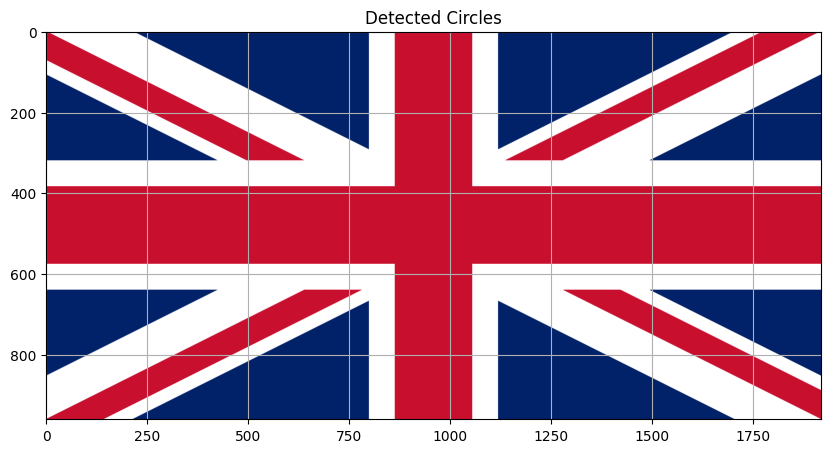

(960, 1920, 3)

In [8]:
flag_img = cv2.imread("a2images/flag.png")
assert img is not None

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.grid(True)
plt.show()

flag_img.shape

In [9]:
points_img = np.array([[200,300], [200,500], [400,360], [400,540]], dtype='float32')
points_flag = np.array([[0, 0], [0,959], [1919,0], [1919,959]], dtype='float32')

def compute_homography(src_pts, dst_pts):

    assert src_pts.shape == dst_pts.shape, "Source and destination points must have the same shape."
    assert src_pts.shape[0] >= 4, "At least 4 point correspondences are needed to compute the homography."
    num_points = src_pts.shape[0]

    A = []
    for i in range(num_points):
        x_src, y_src = src_pts[i][0], src_pts[i][1]
        x_dst, y_dst = dst_pts[i][0], dst_pts[i][1]

        # Two rows per correspondence
        A.append([-x_src, -y_src, -1, 0, 0, 0, x_dst * x_src, x_dst * y_src, x_dst])
        A.append([0, 0, 0, -x_src, -y_src, -1, y_dst * x_src, y_dst * y_src, y_dst])

    A = np.array(A)

    AtA = np.dot(A.T, A)

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(AtA)
    # Get the eigenvector corresponding to the smallest eigenvalue
    smallest_eigenvalue_index = np.argmin(eigenvalues)
    h = eigenvectors[:, smallest_eigenvalue_index]

    # Reshape h into the 3x3 homography matrix
    H = h.reshape(3, 3)
    # Normalize H (if necessary, to make H[2,2] = 1)
    return H

H = compute_homography(points_flag, points_img)
print(H)

[[3.53290338e-04 3.41104404e-11 5.54697937e-01]
 [1.44527874e-04 5.78412933e-04 8.32046889e-01]
 [1.60586532e-07 1.20140696e-13 2.77348967e-03]]


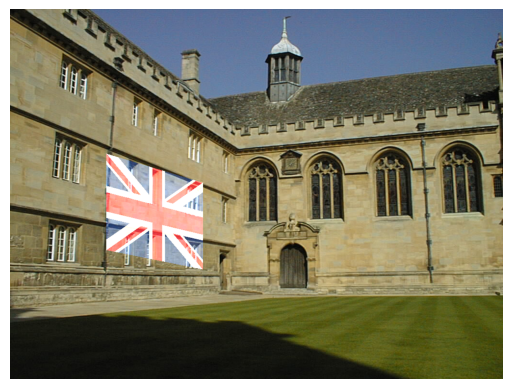

In [10]:
architecture = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
flag = cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB)

# Compute the homography
# Warp the flag image to fit the architectural plane
height, width, channels = architecture.shape
warped_flag = cv2.warpPerspective(flag, H, (width, height))

bg_img = np.ones((height, width, channels), dtype=np.uint8) * 255
# Blend the images
blended_image = cv2.addWeighted(warped_flag, 0.9, architecture , 1, 0)

plt.imshow(blended_image)
plt.axis('off')
plt.show()